<div
  style="
    display: flex;
    justify-content: center;
    flex-direction: column;
    align-items: center;
  "
>
<div style="width: 400px; padding: 20px; background: #111; border: 1px solid #333; color: #eee">
  <p style="opacity: 0.5; margin-bottom: -10px"><i>TDT4173 Machine Learning 2023</i></p>
  <h1 style="margin-bottom: -5px"><b>Short Notebook 2</b></h1>
  <h3>Kaggle Name: NeuralNet Ninjas</h3>
  <br />
  <h3>Team Members:</h3>
  <table style="margin: 0 auto; width: 100%; text-align: left">
    <tr style="background: #222">
      <th style="border-width: 0.5px; border-color: #555">Name</th>
      <th style="border-width: 0.5px; border-color: #555">Student ID</th>
    </tr>
    <tr>
      <td style="border-width: 0.5px; border-color: #555">Antonsen Eggen, Sivert</td>
      <td style="border-width: 0.5px; border-color: #555">123 45 678</td>
    </tr>
    <tr>
      <td style="border-width: 0.5px; border-color: #555">Broch Grude, Kristoffer VI Nicolay</td>
      <td style="border-width: 0.5px; border-color: #555">123 45 678</td>
    </tr>
    <tr>
      <td style="border-width: 0.5px; border-color: #555">Raa, Mathias</td>
      <td style="border-width: 0.5px; border-color: #555">123 45 678</td>
    </tr>
  </table>
  <br />
  <h3 style="margin-bottom: -5px">Runtime: x hours</h3>
  <p style="opacity: 0.5;"><i>Specs: MacBook Pro 2021, Apple M1 Pro Chip, 16 GB RAM</i></p>
  </div>
</div>

---

In [ ]:
# Utils
from IPython.utils import io
import os

# Data
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Scikit-learn
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.model_selection import cross_val_predict, KFold, train_test_split

# Models
from autogluon.tabular import TabularDataset, TabularPredictor
from autogluon.common import space

import tensorflow as tf

import lightgbm as lgb
import xgboost as xgb
import catboost as cb

import scipy.optimize as opt

# 1 - Preprocessing

### 1.1 - Dataset loading

In [ ]:
# Load data

y_data = {}
y_test_data = pd.read_csv(f"../data/test.csv")
X_test_estimated_data = {}
X_train_estimated_data = {}
X_train_observed_data = {}
locations = ["A", "B", "C"]

for location in locations:
    y_data[location] = pd.read_parquet(f"../data/{location}/train_targets.parquet")

    X_test_estimated_data[location] = pd.read_parquet(
        f"../data/{location}/X_test_estimated.parquet"
    )
    X_train_estimated_data[location] = pd.read_parquet(
        f"../data/{location}/X_train_estimated.parquet"
    )
    X_train_observed_data[location] = pd.read_parquet(
        f"../data/{location}/X_train_observed.parquet"
    )

In [ ]:
# Combine data

combine_data = (
    lambda data: pd.concat(data.values(), keys=data.keys())
    .reset_index()
    .drop(columns="level_1")
    .rename(columns={"level_0": "location"})
)

y = combine_data(y_data).sort_values(by=["time", "location"])

y_test_data = y_test_data.rename(columns={"prediction": "pv_measurement"})
y_test_data = y_test_data[["time", "location", "pv_measurement"]]

# Add Kaggle test data to y
y = pd.concat([y, y_test_data]).sort_values(by=["time", "location"])
y["time"] = pd.to_datetime(y["time"])

X_train_observed = combine_data(X_train_observed_data).assign(data_type="observed")
X_train_estimated = combine_data(X_train_estimated_data).assign(data_type="estimated")
X_test_estimated = combine_data(X_test_estimated_data).assign(data_type="test")

X = pd.concat([X_train_observed, X_train_estimated, X_test_estimated]).sort_values(
    by=["date_forecast", "location"]
)

print("X shape:", X.shape)
print("y shape:", y.shape)

C:\Users\krist\AppData\Local\Temp\ipykernel_6096\3349527316.py:16: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype=datetime64[ns])
  y = pd.concat([y, y_test_data]).sort_values(by=["time", "location"])


X shape: (413791, 49)
y shape: (101248, 3)


### 1.2 - Data cleaning

#### 1.2.1 - Resample data to hourly granularity

In [ ]:
# Custom aggregation function
def custom_resample(aggregation_dict): 
    result = {}
    for column in X.columns:
        if column in ["date_forecast"]:
            continue

        aggregation = aggregation_dict.get(column, 'mean')  # Use 'mean' by default

        result[column] = aggregation
    return result

# Specify the aggregation method for specific columns
aggregation_dict = {
    "location": "first",
    "data_type": "first",

    # Categorical weather features
    "is_day:idx": "first",
    "is_in_shadow:idx": "first",
    "precip_type_5min:idx": "first",
    "dew_or_rime:idx": "first",
    "snow_drift:idx": "first",
}

X = (
    X.set_index("date_forecast")
    .groupby("location")
    .resample("H")
    .apply(custom_resample(aggregation_dict))
    .drop(columns=["location"])
    .reset_index()
    .sort_values(by=["date_forecast", "location"])
    .reset_index(drop=True)
)


#### 1.2.2 - Remove NaN rows

In [ ]:
# Find all rows that only contain NaN in X

nan_rows = X[X.drop(columns=["date_forecast", "location"]).isna().all(axis=1)].index

X = X.drop(nan_rows).reset_index(drop=True)
display(X.describe())

# Find all rows that only contain NaN in y

nan_rows = y[y.drop(columns=["time", "location"]).isna().all(axis=1)].index

y = y.drop(nan_rows).reset_index(drop=True)
display(y.describe())

,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,...,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms
count,103450.000000,103450.000000,85710.000000,1.034500e+05,103450.000000,95988.000000,103450.000000,103450.000000,103450.000000,1.034500e+05,...,103450.000000,103450.000000,103450.000000,103450.000000,103450.000000,103450.000000,103450.000000,103450.000000,103450.000000,103450.000000
mean,6.022451,1.255468,2818.218750,5.340856e+05,148.357071,1728.615723,0.002707,275.193604,40.692169,1.464918e+05,...,179.593079,-0.686007,0.056825,279.437866,73.615753,33047.601562,3.017211,0.677701,0.670877,0.000048
std,2.766890,0.037343,2490.028320,8.361419e+05,232.916977,1777.659424,0.254843,7.007302,61.684486,2.194368e+05,...,97.451599,24.151138,0.105932,6.689621,34.070358,17768.091797,1.743118,2.773536,1.871685,0.006387
min,0.500000,1.139250,27.600000,0.000000e+00,0.000000,27.299997,-1.000000,247.425003,0.000000,0.000000e+00,...,6.983000,-49.931999,0.000000,258.024994,0.000000,132.375000,0.025000,-7.225000,-8.400000,-0.100000
25%,4.000000,1.230000,1063.206177,0.000000e+00,0.000000,602.687500,0.000000,270.600006,0.000000,0.000000e+00,...,94.335381,-17.985250,0.000000,274.799988,52.900002,17214.430664,1.675000,-1.325000,-0.600000,0.000000
50%,5.450000,1.255000,1847.675049,1.444562e+04,2.350000,1170.074951,0.000000,275.000000,1.400000,1.314446e+04,...,180.008751,-0.422625,0.000000,278.700012,93.025002,36858.449219,2.675000,0.325000,0.700000,0.000000
75%,7.900000,1.279000,3831.431152,8.463045e+05,233.250000,2085.399902,0.000000,280.649994,68.193748,2.444780e+05,...,264.694176,16.086188,0.100000,284.093758,99.925003,48121.931641,4.025000,2.500000,1.850000,0.000000
max,18.700001,1.441000,12294.901367,2.990596e+06,835.650024,11673.724609,1.000000,294.924988,334.750000,1.198315e+06,...,348.487518,49.943748,1.375000,303.250000,100.000000,75489.328125,13.275000,11.200000,8.825000,0.100000


,pv_measurement
count,95184.000000
mean,280.506347
std,758.866540
min,0.000000
25%,0.000000
50%,0.000000
75%,161.287500
max,5733.420000


#### 1.2.3 - Remove outliers

In [ ]:
# Remove repeated values

def find_repeated_indexes(df, column_name, repeat_count=12, ignore_zeros=True) -> list:
    """
    Find and return the indexes of rows with a specified number of repeated values in a given column.

    Parameters:
    - df: DataFrame to search for repeated rows.
    - column_name: Name of the column to check for repeated values.
    - repeat_count: Number of repeated values required to consider a row as a match.

    Returns:
    - List of indexes for rows with the specified number of repeated values in the given column.
    """
    repeated_indexes = []
    temp_repeated_indexes = []
    current_value = None

    for index, row in df.iterrows():
        value = row[column_name]

        if value == 0 and ignore_zeros:
            continue

        if value == current_value:
            temp_repeated_indexes.append(index)
        else:
            current_value = value
            if len(temp_repeated_indexes) <= repeat_count:
                temp_repeated_indexes.clear()
            else:
                repeated_indexes.extend(
                    set(temp_repeated_indexes) - set(repeated_indexes)
                )
                temp_repeated_indexes.clear()

    return repeated_indexes

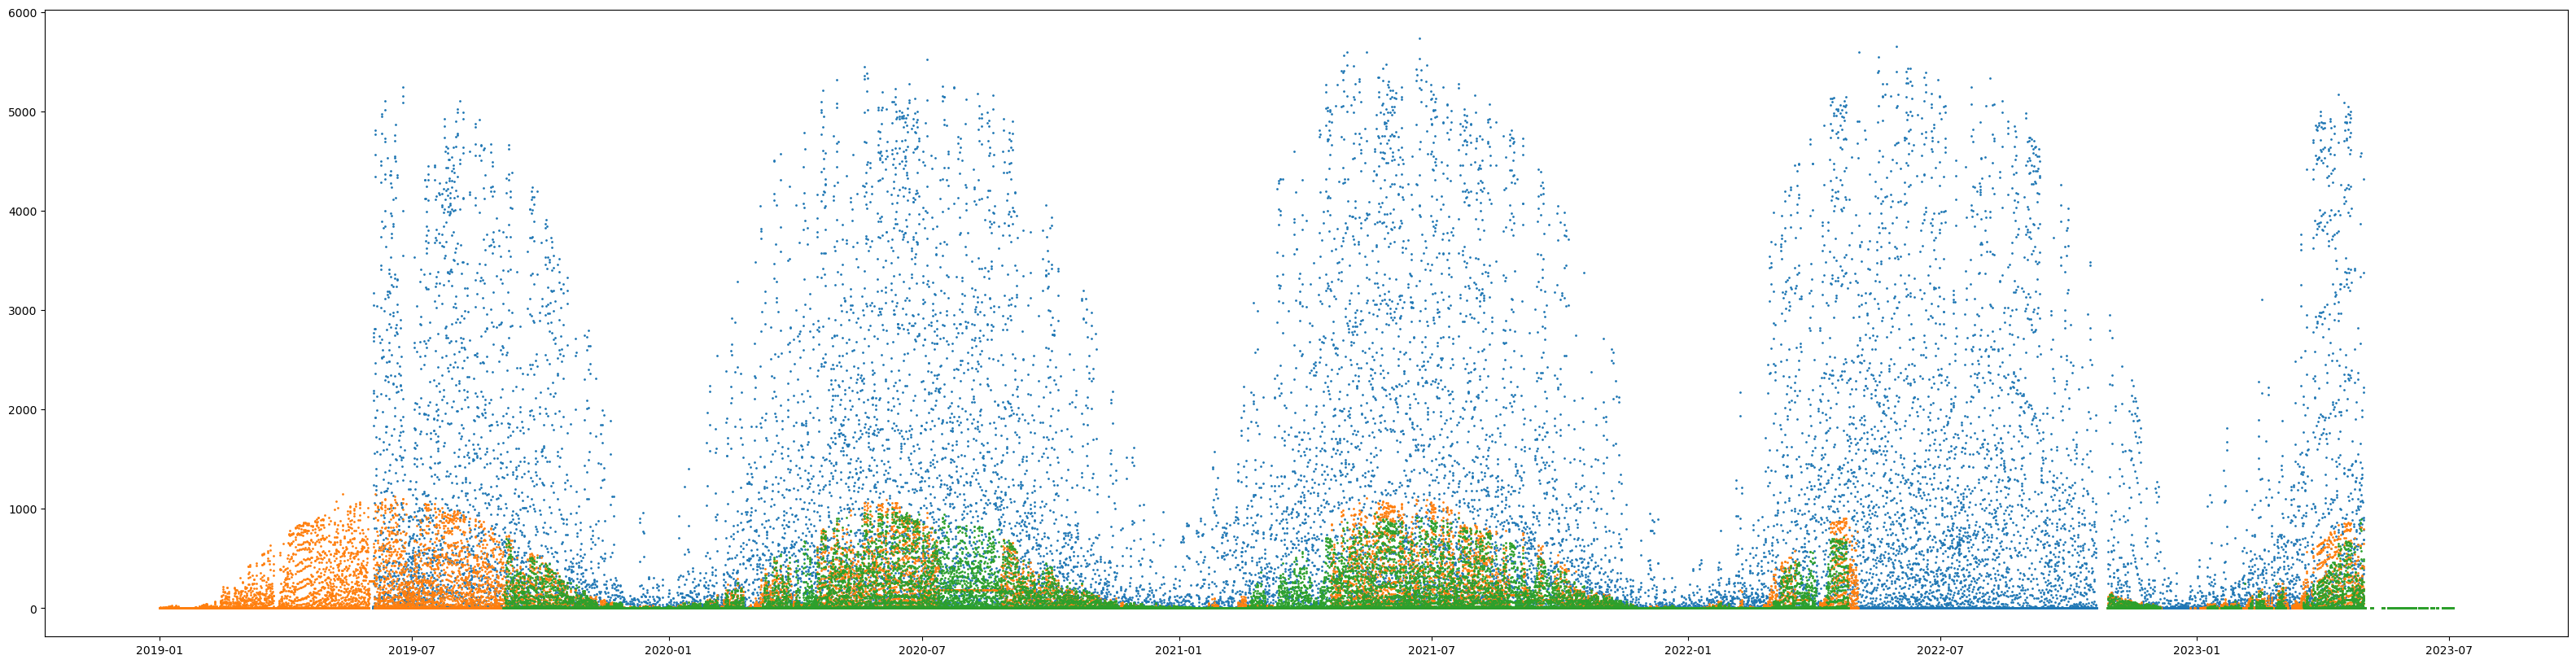

In [ ]:
# Visulize data per location
plt.figure(figsize=(40, 10))

for location in locations:
    plt.scatter(y[y.location == location].time, y[y.location == location]["pv_measurement"], s=1)

### 1.3 - Combine X and y

#### 1.3.1 Create standard preprocessing data

In [ ]:
# Remove repeated values (Version 1)

# Create a copy of X and y
X_standard = X.copy()
y_standard = y.copy()

for location in locations:
    # Drop rows with repeated values over 24 hours
    repeated_indexes = find_repeated_indexes(
        y_standard[y_standard.location == location].sort_values(by=["location", "time"]),
        "pv_measurement",
        repeat_count=24,
        ignore_zeros=True,
    )

    y_standard = y_standard.drop(repeated_indexes).reset_index(drop=True)

    # Drop rows with repeated zeros over 4 days,
    # ignore dates after '2023-05-01 00:00:00' as they are test data

    repeated_indexes = find_repeated_indexes(
        y_standard[(y_standard.location == location) & (y_standard.time <= "2023-05-01 00:00:00")].sort_values(
            by=["location", "time"]
        ),
        "pv_measurement",
        repeat_count=72,
        ignore_zeros=False,
    )

    y_standard = y_standard.drop(repeated_indexes).reset_index(drop=True)

In [ ]:
# Combine X and y on date_forecast and location. Drop rows where a row does not exist in both X and y.

data_standard = pd.merge(
    X_standard, y_standard, left_on=["date_forecast", "location"], right_on=["time", "location"]
).drop(columns=["time"])

#### 1.3.2 Create simple preprocessing data 

In [ ]:
# Remove repeated values (Version 2)

# Create a copy of X and y
X_simple = X.copy()
y_simple = y.copy()

for location in locations:
    # Drop rows with repeated values over 24 hours
    repeated_indexes = find_repeated_indexes(
        y_simple[y_simple.location == location].sort_values(by=["location", "time"]),
        "pv_measurement",
        repeat_count=48,
        ignore_zeros=True,
    )

    y_simple = y_simple.drop(repeated_indexes).reset_index(drop=True)

In [ ]:
# Combine X and y on date_forecast and location. Drop rows where a row does not exist in both X and y.

data_simple = pd.merge(
    X_simple, y_simple, left_on=["date_forecast", "location"], right_on=["time", "location"]
).drop(columns=["time"])

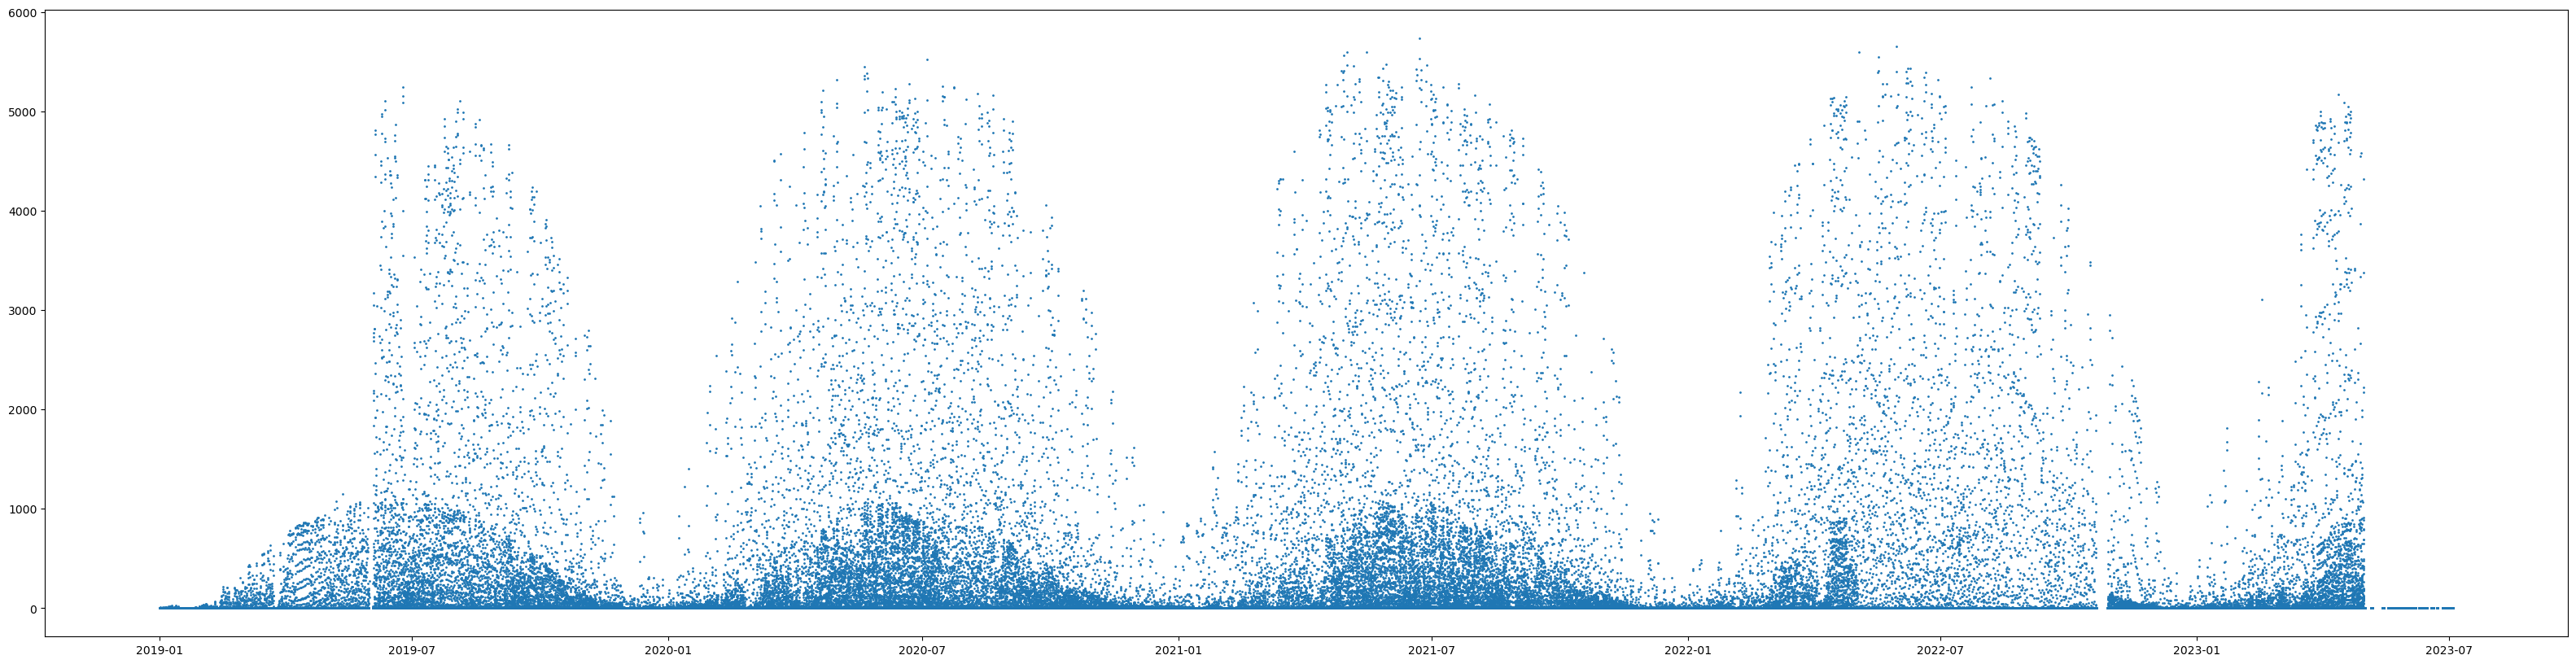

In [ ]:
plt.figure(figsize=(40, 10))
plt.scatter(data_simple.date_forecast, data_simple["pv_measurement"], s=1)

### 1.4 - Feature Engineering

#### 1.4.1 - Add sinus and cosinus features

In [ ]:
# Function that sinus and cosinus transform a column

def add_sin_cos(df, column_name, period):
    """
    Add sinus and cosinus transformed columns for the given column.

    Parameters:
    - df: DataFrame to add the transformed columns to.
    - column_name: Name of the column to transform.
    - period: Period of the sinus and cosinus functions.
    """
    df[f"{column_name}_sin"] = np.sin(2 * np.pi * df[column_name] / period)
    df[f"{column_name}_cos"] = np.cos(2 * np.pi * df[column_name] / period)


In [ ]:
# Add sinus and cosinus transformed columns for time for data_standard

data_standard["hour"] = data_standard["date_forecast"].dt.hour
data_standard["month"] = data_standard["date_forecast"].dt.month

add_sin_cos(data_standard, "hour", 23)
add_sin_cos(data_standard, "month", 12)

In [ ]:
# Add sinus and cosinus transformed columns for time for data_simple

data_simple["hour"] = data_simple["date_forecast"].dt.hour
data_simple["month"] = data_simple["date_forecast"].dt.month

add_sin_cos(data_simple, "hour", 23)
add_sin_cos(data_simple, "month", 12)

#### 1.4.2 - Transform sun_azimuth feature

In [ ]:
# Sun azimuth feature engineering

def convert_from_degree_to_ciruclar(df, feature):
    """
    Converts a feature from degree to circular
    """
    df[feature + "_sin"] = np.sin(np.radians(df[feature]))
    df[feature + "_cos"] = np.cos(np.radians(df[feature]))

    return df

In [ ]:
# Convert sun_azimuth from degree to circular for data_standard
data_standard = convert_from_degree_to_ciruclar(data_standard, "sun_azimuth:d")

In [ ]:
# Convert sun_azimuth from degree to circular for data_standard
data_simple = convert_from_degree_to_ciruclar(data_simple, "sun_azimuth:d")

### 1.5 - Result

In [ ]:
# The two datasets used are data_standard and data_simple

In [ ]:
data_standard.describe().T.drop(columns=["std", "25%", "50%", "75%"])

,count,mean,min,max
absolute_humidity_2m:gm3,85205.0,6.214849,0.700000,1.735000e+01
air_density_2m:kgm3,85205.0,1.252912,1.139250,1.426250e+00
ceiling_height_agl:m,69963.0,2903.989258,27.849998,1.229490e+04
clear_sky_energy_1h:J,85205.0,553656.875000,0.000000,2.990596e+06
clear_sky_rad:W,85205.0,153.780457,0.000000,8.356500e+02
cloud_base_agl:m,78892.0,1748.616577,27.500000,1.167362e+04
dew_or_rime:idx,85205.0,0.015879,-1.000000,1.000000e+00
dew_point_2m:K,85205.0,275.824036,251.050003,2.936250e+02
diffuse_rad:W,85205.0,41.908321,0.000000,3.347500e+02
diffuse_rad_1h:J,85205.0,150879.968750,0.000000,1.198315e+06


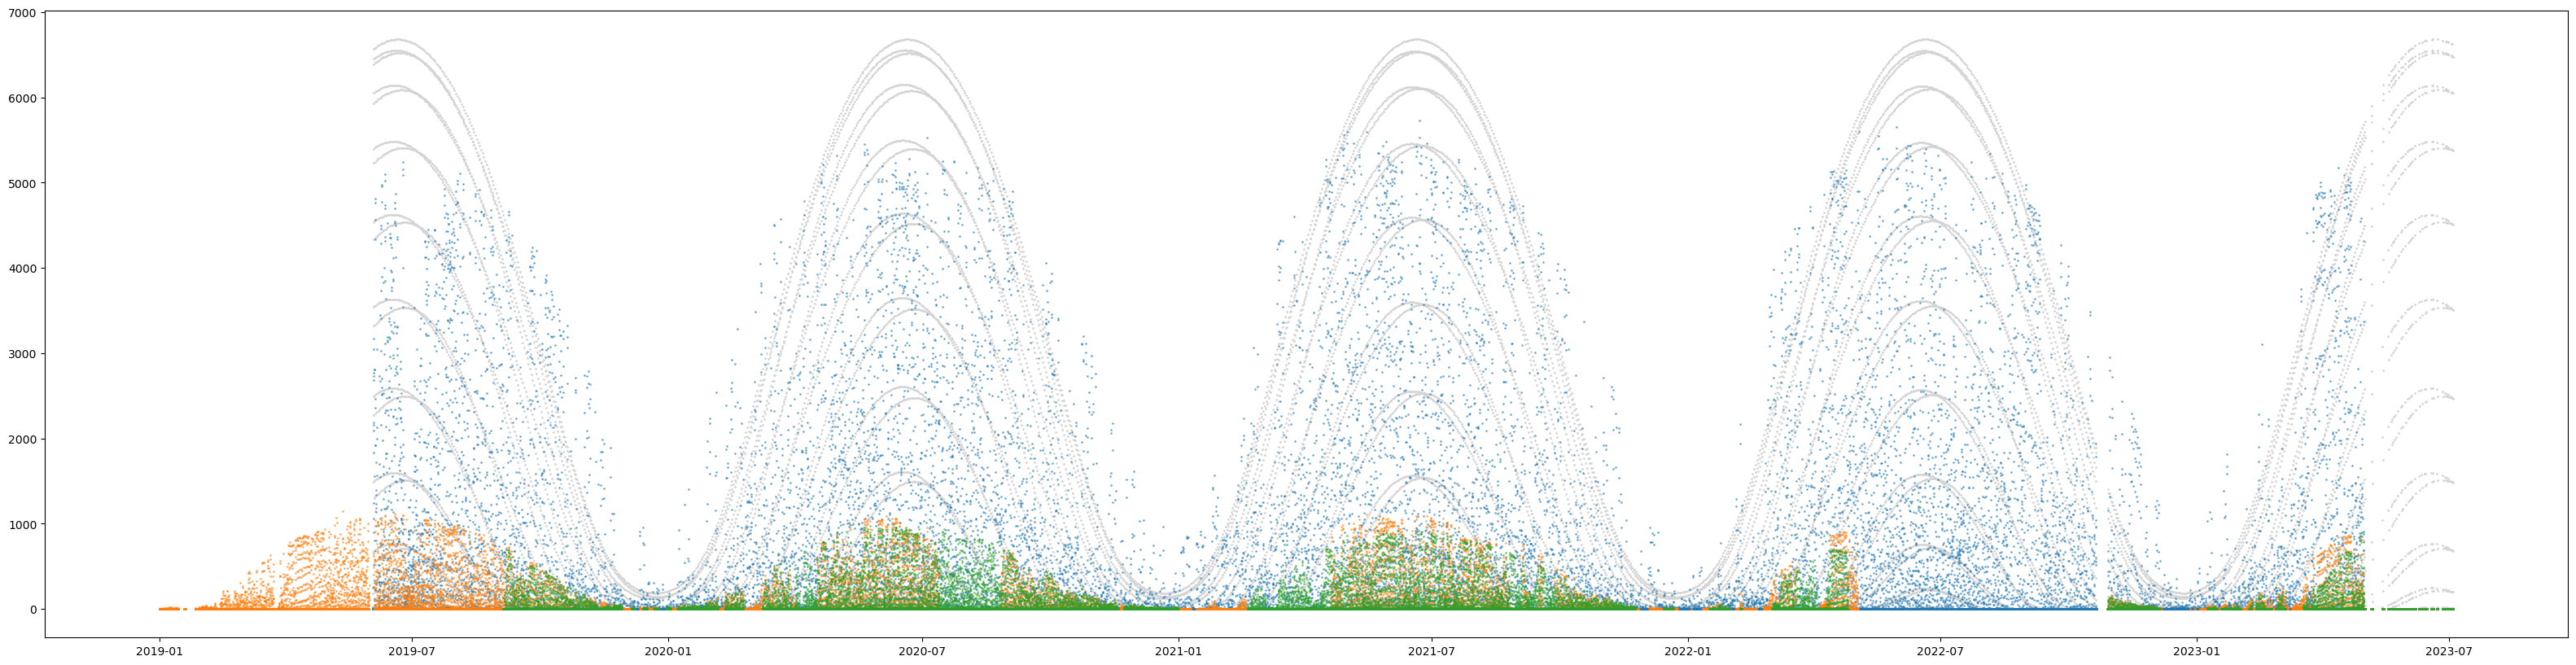

In [ ]:
# Plot alignment and values
plt.figure(figsize=(40, 10))

plt.scatter(
    data_standard[data_standard.location == "A"].date_forecast,
    data_standard[data_standard.location == "A"]["clear_sky_rad:W"] * 8,
    s=1,
    color="lightgrey",
)

for loc in locations:
    plt.scatter(
        data_standard[data_standard.location == loc].date_forecast,
        data_standard[data_standard.location == loc]["pv_measurement"],
        s=1,
        alpha=0.5,
    )

In [ ]:
data_simple.describe().T.drop(columns=["std", "25%", "50%", "75%"])

,count,mean,min,max
absolute_humidity_2m:gm3,92117.0,6.005840e+00,0.500000,1.735000e+01
air_density_2m:kgm3,92117.0,1.255348e+00,1.139250,1.441000e+00
ceiling_height_agl:m,75668.0,2.880849e+03,27.799999,1.229490e+04
clear_sky_energy_1h:J,92117.0,5.239999e+05,0.000000,2.990596e+06
clear_sky_rad:W,92117.0,1.455472e+02,0.000000,8.356500e+02
cloud_base_agl:m,85300.0,1.740147e+03,27.500000,1.167362e+04
dew_or_rime:idx,92117.0,7.447051e-03,-1.000000,1.000000e+00
dew_point_2m:K,92117.0,2.752192e+02,247.425003,2.936250e+02
diffuse_rad:W,92117.0,3.995409e+01,0.000000,3.347500e+02
diffuse_rad_1h:J,92117.0,1.438424e+05,0.000000,1.198315e+06


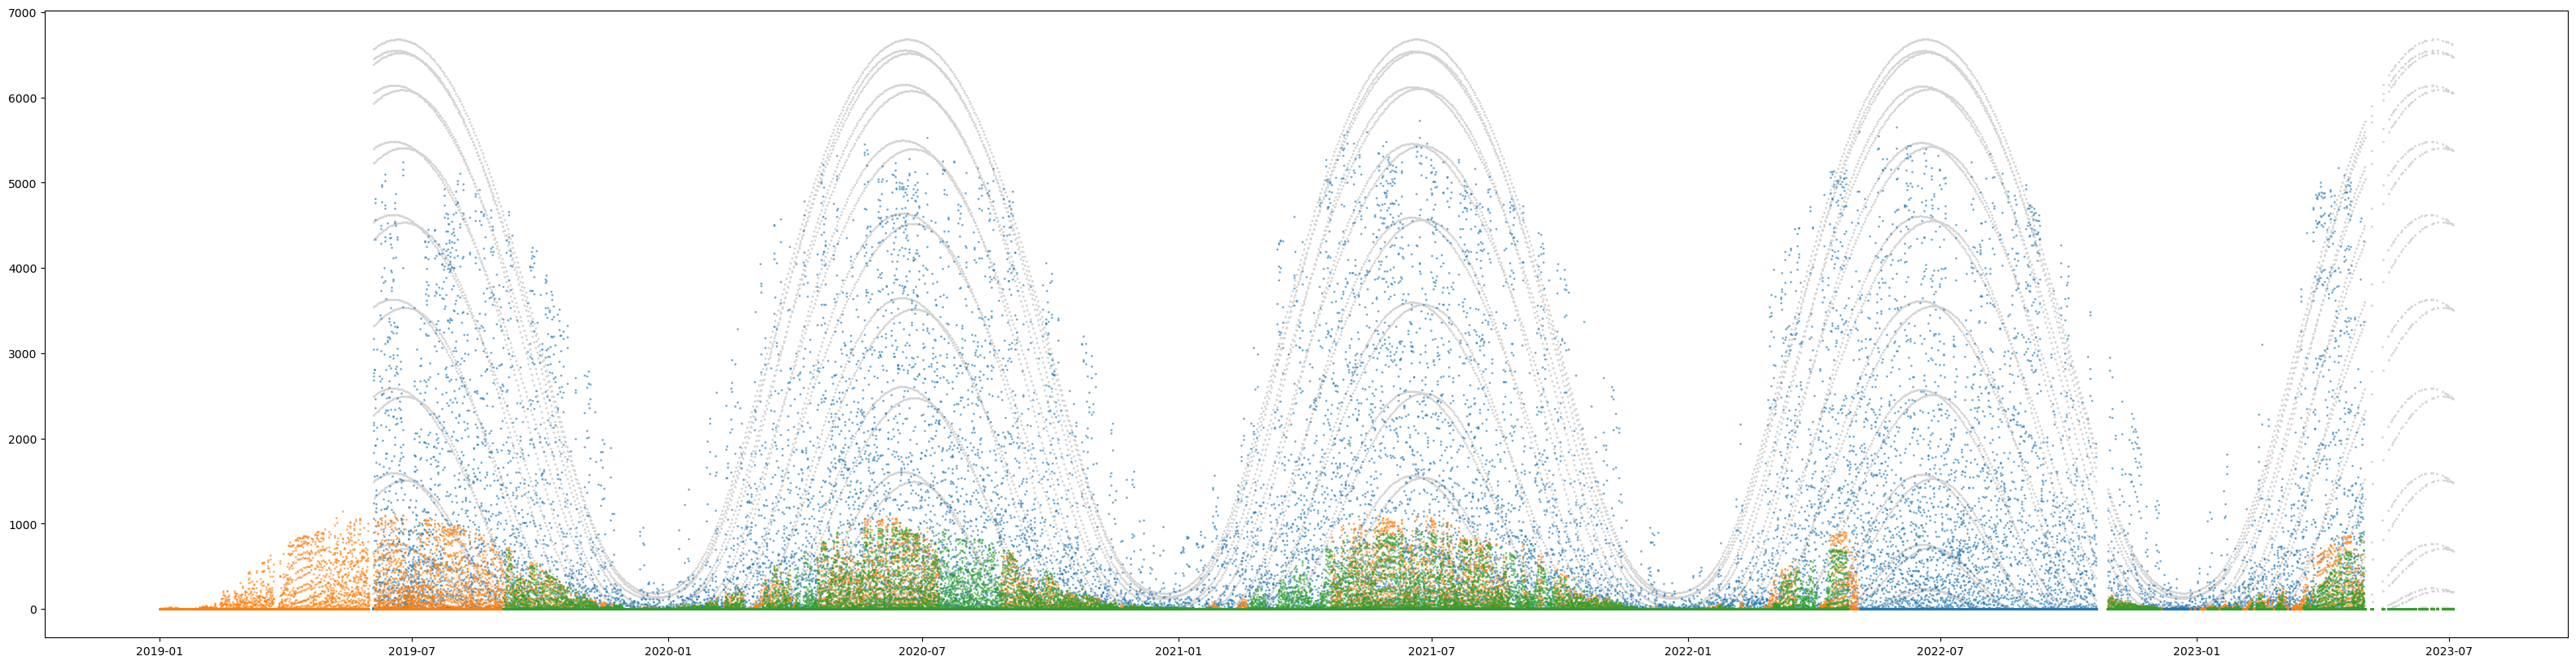

In [ ]:
# Plot alignment and values
plt.figure(figsize=(40, 10))

plt.scatter(
    data_simple[data_simple.location == "A"].date_forecast,
    data_simple[data_simple.location == "A"]["clear_sky_rad:W"] * 8,
    s=1,
    color="lightgrey",
)

for loc in locations:
    plt.scatter(
        data_simple[data_simple.location == loc].date_forecast,
        data_simple[data_simple.location == loc]["pv_measurement"],
        s=1,
        alpha=0.5,
    )

# 2 – Modeling

**Model Stack**
1. Target Encoded Catboost
2. Simple LightGBM
3. Target Log Transform Catboost
4. Location Specific Catboost
5. Location Specific AutoGluon
6. Location Specific FastAI Neural Network

In [ ]:
# Dictionary of all model predictions for final ensambling
test_result = {}

## Model 1 – Target Encoded Catboost

In [ ]:
data_general_catboost_target_encoded = data_simple.copy()

drop_cols = [
    "cloud_base_agl:m",
    "ceiling_height_agl:m",
    "snow_density:kgm3",
    "hour",
    "month",
    "date_calc",
    "date_forecast",
    "clear_sky_rad:W",
]

data_general_catboost_target_encoded["pv_measurement"] = data_general_catboost_target_encoded["pv_measurement"]

mean_target = (
    data_general_catboost_target_encoded[
        data_general_catboost_target_encoded.data_type.isin(["observed", "estimated"])
    ]
    .groupby(["location", "month", "hour"])["pv_measurement"]
    .mean()
)

location_mapping = mean_target.to_dict()

data_general_catboost_target_encoded[
    "location_encoded"
] = data_general_catboost_target_encoded.apply(
    lambda x: location_mapping.get((x["location"], x["month"], x["hour"]), None), axis=1
)


data_general_catboost_target_encoded = data_general_catboost_target_encoded.drop(
    drop_cols, axis=1
)

ignore_cols = [
    "location",
    "dew_or_rime:idx",
    "is_day:idx",
    "is_in_shadow:idx",
    "pv_measurement",
    "data_type",
]

cols = [
    col for col in data_general_catboost_target_encoded.columns if col not in ignore_cols
]

data_general_catboost_target_encoded, _, y_scaler = scale_data(
    data_general_catboost_target_encoded, cols=cols
)

# Create training and test data
train = (
    data_general_catboost_target_encoded[
        data_general_catboost_target_encoded["data_type"].isin(["observed", "estimated"])
    ]
    .drop(columns=["data_type"])
    .copy()
)
test = (
    data_general_catboost_target_encoded[
        data_general_catboost_target_encoded["data_type"] == "test"
    ]
    .drop(columns=["data_type"])
    .copy()
)

In [ ]:
pv_measurement = train["pv_measurement"]
train.drop("pv_measurement", axis=1, inplace=True)

cat_features = [0]
model_params = {
    "iterations": 1000,
    "depth": 9,
    "loss_function": "MAE",
    "cat_features": cat_features,
}

# Initialize lists to store the predictions
all_preds = pd.DataFrame()
temp_test_result = []

# Create a CatBoostRegressor instance for this fold
model = catboost.CatBoostRegressor(**model_params)

# Fit the model
model.fit(train, pv_measurement)

# Get predictions for the validation set
preds = model.predict(test)

In [ ]:
test_result["encoded_catboost"] = pd.DataFrame(
    y_scaler.inverse_transform(preds.reshape(-1, 1)), columns=["pv_measurement"]
)
test_result["encoded_catboost"]["pv_measurement"] = test_result[
    "encoded_catboost"
].values

## Model 2 – Simple LightGBM

In [ ]:
data_general_lgb = data_simple.copy()

drop_cols = [
    "cloud_base_agl:m",
    "ceiling_height_agl:m",
    "snow_density:kgm3",
    "month_sin",
    "hour_sin",
    "month_cos",
    "hour_cos",
    "date_calc",
    "sun_azimuth:d_sin",
    "sun_azimuth:d_cos",
    "date_forecast",
    "elevation:m",
    "precip_5min:mm",
    "precip_type_5min:idx",
    "snow_drift:idx",
    "wind_speed_u_10m:ms",
    "wind_speed_v_10m:ms",
    "wind_speed_w_1000hPa:ms",
]

data_general_lgb = data_general_lgb.drop(drop_cols, axis=1)
data_general_lgb.columns = [
    column.replace(":", "_") for column in data_general_lgb.columns
]

ignore_cols = [
    "location",
    "is_day_idx",
    "is_in_shadow_idx",
    "pv_measurement",
    "data_type",
]

data_general_lgb["is_day_idx"] = data_general_lgb["is_day_idx"].astype("int")
data_general_lgb["is_in_shadow_idx"] = data_general_lgb["is_in_shadow_idx"].astype("int")
data_general_lgb["dew_or_rime_idx"] = data_general_lgb["dew_or_rime_idx"].astype("int")

cols = [col for col in data_general_lgb.columns if col not in ignore_cols]

data_general_lgb, _, y_scaler = scale_data(data_general_lgb, cols=cols)

# location one-hot
data_general_lgb = pd.get_dummies(data_general_lgb, columns=["location"])

# Create training and test data
test = data_general_lgb[data_general_lgb["data_type"].isin(["test"])].drop(columns=["data_type"]).copy()
train = data_general_lgb[data_general_lgb["data_type"].isin(["observed", "estimated"])].drop(columns=["data_type"]).copy()

In [ ]:
pv_measurement = train["pv_measurement"]

model_params = {
    "metric": "MSE",
    "max_depth": 6,
    "num_rounds": 200,
    "colsample_bytree": 0.6,
    "learning_rate": 0.04,
    "num_leaves": 140,
}

# Create a CatBoostRegressor instance for this fold
model = lgb.LGBMRegressor(**model_params)

# Fit the model
model.fit(train.drop(columns=["pv_measurement"]), pv_measurement)

# Get predictions for the validation set
preds = model.predict(test.drop(columns=["pv_measurement"]))

In [ ]:
test_result["general_lightgbm"] = pd.DataFrame(y_scaler.inverse_transform(preds.reshape(-1, 1)), columns=["pv_measurement"])

## Model 3 – Target Log Transform Catboost

In [ ]:
data_general_catboost_transform = data_simple.copy()


# Drop columns that are not needed
drop_cols = [
    "cloud_base_agl:m",
    "ceiling_height_agl:m",
    "snow_density:kgm3",
    "hour",
    "month",
    "date_calc",
    "date_forecast",
    "clear_sky_rad:W",
    # "sun_azimuth:d",
]

data_general_catboost_transform["pv_measurement"] = np.log1p(
    data_general_catboost_transform["pv_measurement"]
)

data_general_catboost_transform = data_general_catboost_transform.drop(
    drop_cols, axis=1
)

ignore_cols = [
    "location",
    "dew_or_rime:idx",
    "is_day:idx",
    "is_in_shadow:idx",
    "pv_measurement",
    "data_type",
]

cols = [
    col for col in data_general_catboost_transform.columns if col not in ignore_cols
]

data_general_catboost_transform, _, y_scaler = scale_data(
    data_general_catboost_transform, cols=cols
)

# Create training and test data
train = (
    data_general_catboost_transform[
        data_general_catboost_transform["data_type"].isin(["observed", "estimated"])
    ]
    .drop(columns=["data_type"])
    .copy()
)
test = (
    data_general_catboost_transform[
        data_general_catboost_transform["data_type"] == "test"
    ]
    .drop(columns=["data_type"])
    .copy()
)

In [ ]:
pv_measurement = train["pv_measurement"]
train.drop("pv_measurement", axis=1, inplace=True)

cat_features = [0]
model_params = {
    "iterations": 1000,
    "depth": 9,
    "loss_function": "MAE",
    "cat_features": cat_features,
}

# For final predictions
# Create a CatBoostRegressor instance for this fold
model = catboost.CatBoostRegressor(**model_params)

# Fit the model
model.fit(train, pv_measurement)

# Get predictions for the validation set
preds = model.predict(test)

In [ ]:
test_result["transform_catboost"] = pd.DataFrame(
    y_scaler.inverse_transform(preds.reshape(-1, 1)), columns=["pv_measurement"]
)
test_result["transform_catboost"]["pv_measurement"] = np.expm1(
    test_result["transform_catboost"].values
)

## Model 4 – Location Specific Catboost

In [ ]:
catboost_location = data_simple.copy()

# Drop columns that are not needed
drop_cols = [
    "cloud_base_agl:m",
    "ceiling_height_agl:m",
    "snow_density:kgm3",
    "hour",
    "month",
    "date_calc",
    "date_forecast",
    # "sun_azimuth:d",
]

catboost_location = catboost_location.drop(drop_cols, axis=1)

# transform the target variable by subtracting direct radiation and diffuse radiation:
catboost_location["estimated"] = np.where(
    catboost_location.data_type.isin(["estimated", "test"]), 1, 0
)

# scaling the data
ignore_cols = [
    "location",
    "dew_or_rime:idx",
    "is_day:idx",
    "is_in_shadow:idx",
    "data_type",
    "estimated"
]

cols = [col for col in catboost_location.columns if col not in ignore_cols]

# Create training and test data

train_all = catboost_location[catboost_location.data_type.isin(["observed", "estimated"])].drop(columns="data_type").copy()
test = catboost_location[catboost_location.data_type == "test"].drop(columns="data_type").copy()

In [ ]:
model_params = {
    "iterations": 1000,
    "depth": 9,
    "loss_function": "MAE",
}

final_preds = []

for location in ("A", "B", "C"):
    train = train_all[train_all.location == location].drop(columns=["location"])

    train_pool = catboost.Pool(data=train.drop(columns="pv_measurement"), label=train["pv_measurement"], cat_features=["estimated"])
    test_pool = catboost.Pool(data=test[test.location == location].drop(columns=["pv_measurement", "location"]), cat_features=["estimated"])

    # Create a CatBoostRegressor instance for this fold
    model = catboost.CatBoostRegressor(**model_params)

    # Fit the model
    model.fit(train_pool)

    # Get predictions for the validation set
    preds = model.predict(test_pool)

    # Invert scaling for the validation set predictions
    prediction_df = pd.DataFrame(preds, columns=["prediction"], index=test[test.location == location].index)
    prediction_df["location"] = location

    # Append the predictions to the list
    final_preds.append(prediction_df)

In [ ]:
test_result["location_catboost"] = pd.concat(final_preds).reset_index().sort_values(["location", "index"]).drop(columns="index")

## Model 5 – Location Specific AutoGluon

In [ ]:
data_autogluon = data_simple.copy()

drop_cols = [
    "ceiling_height_agl:m",
    "cloud_base_agl:m",
    "snow_density:kgm3",
    "elevation:m",
    "snow_drift:idx",
    "date_calc",
    "sun_azimuth:d_sin",
    "sun_azimuth:d_cos",
    "prob_rime:p",
    "fresh_snow_1h:cm",
    "dew_or_rime:idx",
    "fresh_snow_3h:cm",
    "hour",
    "month",
    "hour_sin",
    "hour_cos",
    "month_sin",
    "month_cos",
    "year",
    "day",
    "global_rad"
]

data_autogluon["year"] = data_autogluon["date_forecast"].dt.year
data_autogluon["day"] = data_autogluon["date_forecast"].dt.dayofyear
data_autogluon["global_rad"] = data_autogluon["direct_rad:W"] + data_autogluon["diffuse_rad:W"]


data_autogluon["global_rad_-1"] = (
    data_autogluon.groupby(["location", "year", "day"])["global_rad"].shift(-1).fillna(0)
)

data_autogluon["precip_5min:mm-2"] = (
    data_autogluon.groupby(["location", "year", "day"])["precip_5min:mm"]
    .shift(-2)
    .fillna(0)
)
data_autogluon["rain_water:kgm2-2"] = (
    data_autogluon.groupby(["location", "year", "day"])["rain_water:kgm2"]
    .shift(-2)
    .fillna(0)
)

# avg rainfall per month calculated from estimated/observed
sum_rainfall = (
    data_autogluon.loc[data_autogluon["data_type"].isin(["observed", "estimated"])]
    .groupby("month")["precip_5min:mm"]
    .sum()
    .reset_index()
    .rename(columns={"precip_5min:mm": "sum_rainfall"})
)

data_autogluon = data_autogluon.merge(sum_rainfall, on="month", how="left")

# avg tmp per month calculated from estimated/observed
sum_wind = (
    data_autogluon.loc[data_autogluon["data_type"].isin(["observed", "estimated"])]
    .groupby("month")["wind_speed_10m:ms"]
    .sum()
    .reset_index()
    .rename(columns={"wind_speed_10m:ms": "sum_wind"})
)


data_autogluon = data_autogluon.merge(sum_wind, on="month", how="left")

median_wind_hourly = (
    data_autogluon.loc[data_autogluon["data_type"].isin(["observed", "estimated"])]
    .groupby(["month", "hour"])["wind_speed_10m:ms"]
    .median()
    .reset_index()
    .rename(columns={"wind_speed_10m:ms": "median_wind_hourly"})
)

data_autogluon = data_autogluon.merge(median_wind_hourly, on=["month", "hour"], how="left")


data_autogluon["estimated"] = np.where(
    data_autogluon["data_type"].isin(["estimated", "test"]), "e", "o"
)

data_autogluon = data_autogluon.drop(drop_cols, axis=1)

test = data_autogluon[data_autogluon["data_type"].isin(["test"])].copy().drop(columns=["data_type"])

train, val = train_test_split(
    data_autogluon[data_autogluon["data_type"].isin(["estimated"])],
    test_size=0.40,
    random_state=1111,
)

train = pd.concat([data_autogluon[data_autogluon["data_type"].isin(["observed"])], train])
train = train.drop(columns=["data_type"])
val = val.drop(columns=["data_type"])

In [ ]:
# Initialize and train AutoGluon model
tabular_predictor = TabularPredictor(label="pv_measurement", eval_metric="mae")

predictor_A = tabular_predictor.fit(
    train_data=train[train.location == "A"],
    tuning_data=val[val.location == "A"],
    presets="best_quality",
    auto_stack=True,
    use_bag_holdout=True,
    num_stack_levels=0,
    time_limit=60*60*3.5,
)

In [ ]:
# Initialize and train AutoGluon model
tabular_predictor = TabularPredictor(label="pv_measurement", eval_metric="mae")

predictor_B = tabular_predictor.fit(
    train_data=train[train.location == "B"],
    tuning_data=val[val.location == "B"],
    presets="best_quality",
    auto_stack=True,
    use_bag_holdout=True,
    num_stack_levels=0,
    time_limit=60*60*2.5,
)

In [ ]:
# Initialize and train AutoGluon model
tabular_predictor = TabularPredictor(label="pv_measurement", eval_metric="mae")

predictor_C = tabular_predictor.fit(
    train_data=train[train.location == "C"],
    tuning_data=val[val.location == "C"],
    presets="best_quality",
    auto_stack=True,
    use_bag_holdout=True,
    num_stack_levels=0,
    time_limit=60*60*2.5,
)

In [ ]:
# Make predictions on the test dataset
test_data_nolab = test.drop(columns=["pv_measurement"])

y_pred_A = predictor_A.predict(
    test_data_nolab[test_data_nolab.location == "A"]
)
y_pred_B = predictor_B.predict(
    test_data_nolab[test_data_nolab.location == "B"]
)
y_pred_C = predictor_C.predict(
    test_data_nolab[test_data_nolab.location == "C"]
)

# Add autogluon result to dataframe
autogluon_result = pd.DataFrame(y_pred_A)
autogluon_result["location"] = "A"
autogluon_result = pd.concat([autogluon_result, pd.DataFrame(y_pred_B)], axis=0)
autogluon_result = autogluon_result.fillna("B")
autogluon_result = pd.concat([autogluon_result, pd.DataFrame(y_pred_C)], axis=0)
autogluon_result = autogluon_result.fillna("C")

test_result["autogluon"] = autogluon_result

## Model 6 – Location Specific FastAI Neural Network

In [ ]:
data_neural = data_standard.copy()

# Drop columns that are not needed
drop_cols = [
    "cloud_base_agl:m",
    "ceiling_height_agl:m",
    "snow_density:kgm3",
    "hour",
    "month",
    "date_calc",
    "date_forecast",
    "elevation:m",
    "fresh_snow_12h:cm",
    "year",
    "day",
    "global_rad"
]

# Target transformation
data_neural["pv_measurement"] = data_neural["pv_measurement"]

data_neural["global_rad"] = data_neural["direct_rad:W"] + data_neural["diffuse_rad:W"]


data_neural["year"] = data_neural["date_forecast"].dt.year
data_neural["day"] = data_neural["date_forecast"].dt.dayofyear

data_neural["global_rad_-1"] = (
    data_neural.groupby(["location", "year", "day"])["global_rad"].shift(-1).fillna(0)
)

data_neural["precip_5min:mm-2"] = (
    data_neural.groupby(["location", "year", "day"])["precip_5min:mm"]
    .shift(-2)
    .fillna(0)
)
data_neural["rain_water:kgm2-2"] = (
    data_neural.groupby(["location", "year", "day"])["rain_water:kgm2"]
    .shift(-2)
    .fillna(0)
)
data_neural["precip_5min:mm-2"] = (
    data_neural.groupby(["location", "year", "day"])["precip_5min:mm"]
    .shift(-2)
    .fillna(0)
)

# Agregations

data_neural["total_clouds_rolling_3"] = (
    data_neural.groupby(["location", "year", "day"])["total_cloud_cover:p"]
    .rolling(3)
    .mean()
    .fillna(0)
    .reset_index()["total_cloud_cover:p"]
)
data_neural["precip_5min_rolling_3"] = (
    data_neural.groupby(["location", "year", "day"])["precip_5min:mm"]
    .rolling(3)
    .mean()
    .fillna(0)
    .reset_index()["precip_5min:mm"]
)

# avg rainfall per month calculated from estimated/observed
sum_rainfall = (
    data_neural.loc[data_neural["data_type"].isin(["observed", "estimated"])]
    .groupby("month")["precip_5min:mm"]
    .sum()
    .reset_index()
    .rename(columns={"precip_5min:mm": "sum_rainfall"})
)

data_neural = data_neural.merge(sum_rainfall, on="month", how="left")

# avg tmp per month calculated from estimated/observed
sum_wind = (
    data_neural.loc[data_neural["data_type"].isin(["observed", "estimated"])]
    .groupby("month")["wind_speed_10m:ms"]
    .sum()
    .reset_index()
    .rename(columns={"wind_speed_10m:ms": "sum_wind"})
)


data_neural = data_neural.merge(sum_wind, on="month", how="left")

median_wind_hourly = (
    data_neural.loc[data_neural["data_type"].isin(["observed", "estimated"])]
    .groupby(["month", "hour"])["wind_speed_10m:ms"]
    .median()
    .reset_index()
    .rename(columns={"wind_speed_10m:ms": "median_wind_hourly"})
)

data_neural = data_neural.merge(median_wind_hourly, on=["month", "hour"], how="left")

data_neural["estimated"] = np.where(
    data_neural.data_type.isin(["estimated", "test"]), 1, 0
)

data_neural = data_neural.drop(drop_cols, axis=1)

ignore_cols = [
    "location",
    "dew_or_rime:idx",
    "is_day:idx",
    "is_in_shadow:idx",
    "pv_measurement",
    "data_type",
    "precip_type_5min:idx",
]

cols = [col for col in data_neural.columns if col not in ignore_cols]

train_df = (
    data_neural[data_neural["data_type"].isin(["observed", "estimated"])]
    .copy()
    .drop(columns=["data_type"])
)
test_df = (
    data_neural[data_neural["data_type"] == "test"].copy().drop(columns=["data_type"])
)

In [ ]:
# Assuming you have a DataFrame named 'df' containing your data
dep_var = "pv_measurement"
cat_names = [
    "estimated",
    "dew_or_rime:idx",
    "precip_type_5min:idx",
]  # List of categorical variable names if any
cont_names = [
    col for col in train_df.columns if col not in cat_names + [dep_var, "location"]
]

procs = [
    fastai.tabular.all.Categorify,
    fastai.tabular.all.FillMissing,
    fastai.tabular.all.Normalize,
]  # Data preprocessing steps

all_preds = pd.DataFrame(columns=["prediction"])

importances = {"A": None, "B": None, "C": None}

for location in ("A", "B", "C"):
    fastai.tabular.all.set_seed(42)

    splits = RandomSplitter(seed=42)(
        train_df[train_df.location == location]
        .copy()
        .drop(
            columns=["location"],
            errors="ignore",
        )
    )

    to = fastai.tabular.all.TabularPandas(
        train_df.copy()[train_df.location == location].drop(
            columns=["location"],
            errors="ignore",
        ),
        procs=procs,
        cat_names=cat_names,
        cont_names=[
            col
            for col in train_df.columns
            if col not in cat_names + [dep_var, "location"]
        ],
        y_names=dep_var,
        splits=splits,
        y_block=fastai.tabular.all.RegressionBlock(),
    )

    dls = to.dataloaders(bs=128, seed=42)

    config = tabular_config(ps=0.2)
    # layers=[512, 256, 128, 62],
    learn = fastai.tabular.all.tabular_learner(
        dls,
        # config=config,
        metrics=[fastai.losses.L1LossFlat()],
        loss_func=fastai.losses.L1LossFlat(),
        # layers=[512, 256, 128, 62],
        y_range=(0, train_df[train_df.location == location].pv_measurement.max()),
    )

    lr = learn.lr_find()

    learn.fit_one_cycle(20, lr)

    tst_dl = learn.dls.test_dl(
        test_df[test_df.location == location]
        .copy()
        .drop(
            columns=["location"],
            errors="ignore",
        )
    )
    preds, _ = learn.get_preds(dl=tst_dl)

    all_preds = pd.concat(
        [all_preds, pd.DataFrame(preds.numpy(), columns=["prediction"])]
    )

In [ ]:
test_result["neural_net"] = all_preds

# 3 – Postprocessing

In [ ]:
constraint = (
    data_standard[data_standard["data_type"].isin(["observed"]) & data_standard["month"].isin([5, 6, 7])]
    .groupby(["month", "hour", "location"])["pv_measurement"]
    .max()
    .reset_index()
)

In [ ]:
kaggle_data = (
    data_standard[data_standard.data_type.isin(["test"])]
    .sort_values(["location", "date_forecast"])
    .copy()
).reset_index(drop=True)

kaggle_data["pv_measurement"] = ensamble
kaggle_data["pv_measurement_post"] = pd.merge(
    kaggle_data, constraint, on=["hour", "month", "location"], how="left"
)["pv_measurement_y"].values
kaggle_data["pv_measurement_post"] = np.where(
    kaggle_data["pv_measurement_post"] < kaggle_data["pv_measurement"],
    kaggle_data["pv_measurement_post"],
    kaggle_data["pv_measurement"],
)
kaggle_data["pv_measurement_post"] = np.where(
    kaggle_data["pv_measurement_post"] < 4, 0, kaggle_data["pv_measurement_post"]
)

In [ ]:
np.sum(kaggle_data["pv_measurement"] - kaggle_data["pv_measurement_post"]) / 2160

# 4 – Submission

In [ ]:
output_df = pd.DataFrame(
    kaggle_data["pv_measurement_post"].values, columns=["prediction"]
)
output_df = output_df.reset_index(names="id")
output_df.to_csv(
    "../data/results/" + str(datetime.datetime.now()) + "-ensamble.csv", index=False
)